# Proyecto: Predicción de Abandono de Clientes Bancarios

## Introducción a los Datasets

### Dataset 1: Predicción de Abandono de Clientes Bancarios (Bank Customer Churn)

**Descripción General:**
Este conjunto de datos contiene información sobre clientes de un banco y su comportamiento, con el objetivo de predecir si un cliente abandonará o no el banco (*churn*). La variable objetivo es `Exited`, que indica si el cliente dejó de ser parte del banco (`1`) o si permaneció (`0`).

**Características del Dataset (Variables relevantes):**
- `CustomerId`: Identificador único del cliente.
- `Surname`: Apellido del cliente.
- `CreditScore`: Puntuación de crédito del cliente.
- `Geography`: País de residencia (ej. Francia, España, Alemania).
- `Gender`: Género del cliente.
- `Age`: Edad del cliente.
- `Tenure`: Años de permanencia en el banco.
- `Balance`: Saldo promedio del cliente.
- `NumOfProducts`: Número de productos que el cliente tiene con el banco.
- `HasCrCard`: Indica si tiene tarjeta de crédito.
- `IsActiveMember`: Indica si el cliente es considerado activo.
- `EstimatedSalary`: Salario estimado del cliente.
- `Exited`: (Variable objetivo) `1` si el cliente se fue del banco, `0` si sigue.

**Objetivo del Proyecto:**
Analizar los factores que influyen en la decisión de un cliente de abandonar el banco. A partir de esto, se puede crear un modelo predictivo que ayude al banco a identificar clientes en riesgo y tomar medidas preventivas de retención.



## 1. Información General
- **Nombre del Proyecto**: 
- **Nombres del Equipo y Roles**:
  - José Villarreal - Lider Tecnico
  - Yohana banda - Lider BI
  - Justin Ureña - Analista
  - José Lara - Analista
  - Gabriela Vivas- Analista
- **Resumen del Proyecto**:
Este proyecto busca identificar los factores que influyen en el abandono de clientes usando modelos de analítica de negocios y aprendizaje automático.

## 2. Perspectiva del Negocio
- Contexto del problema y por qué es relevante en el entorno empresarial.
- Impacto potencial de las predicciones.
- Aplicaciones reales en la toma de decisiones.

## 3. Análisis Exploratorio de Datos
- Cargar dataset.
- Revisar estructura de datos.
- Estadísticas descriptivas.
- Visualización inicial.

In [45]:
# Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb 
from lightgbm import early_stopping

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score,
    precision_score, roc_auc_score, recall_score, ConfusionMatrixDisplay
)
from imblearn.pipeline import Pipeline as imbpipeline


In [ ]:
# Análisis Exploratorio de Datos (EDA)
# Cargar datos
df = pd.read_csv('Churn_Modelling.csv')

# Revisar estructura
print("\nInformación del dataset:")
df.info()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(df.describe())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Estadísticas descriptivas:
       RowNumber  CustomerId  CreditScor

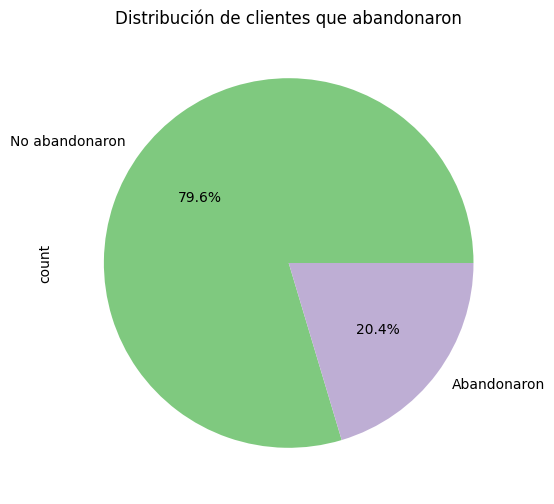

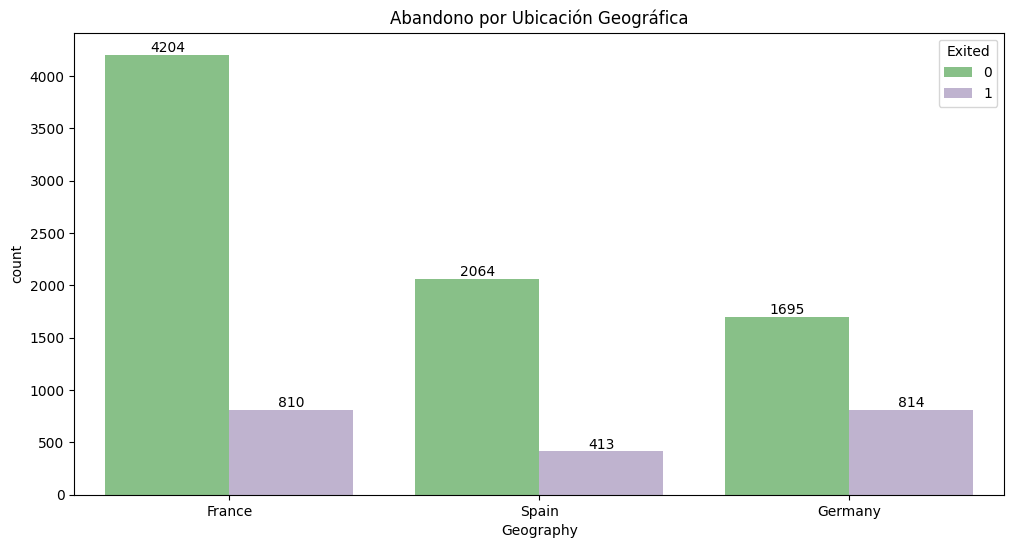

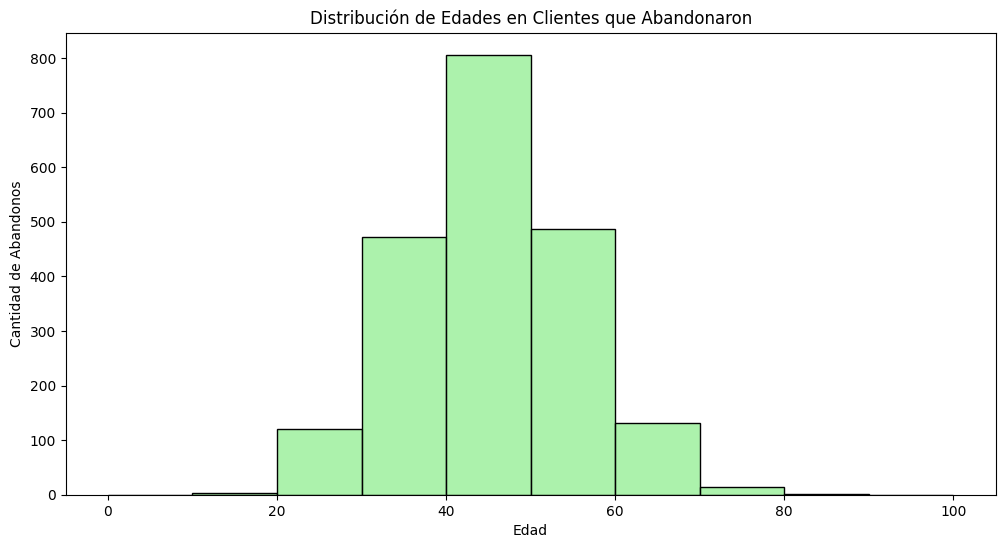

C:\Users\Darki\AppData\Local\Temp\ipykernel_22556\1167372105.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y="Balance", data=df, palette="Accent")


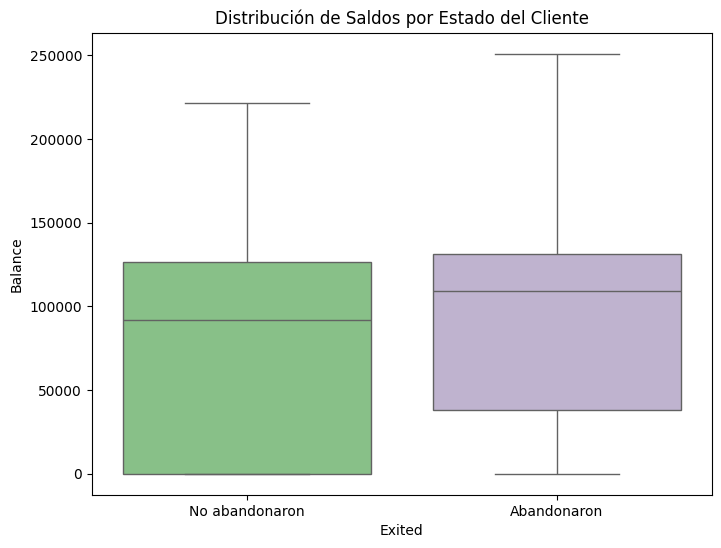

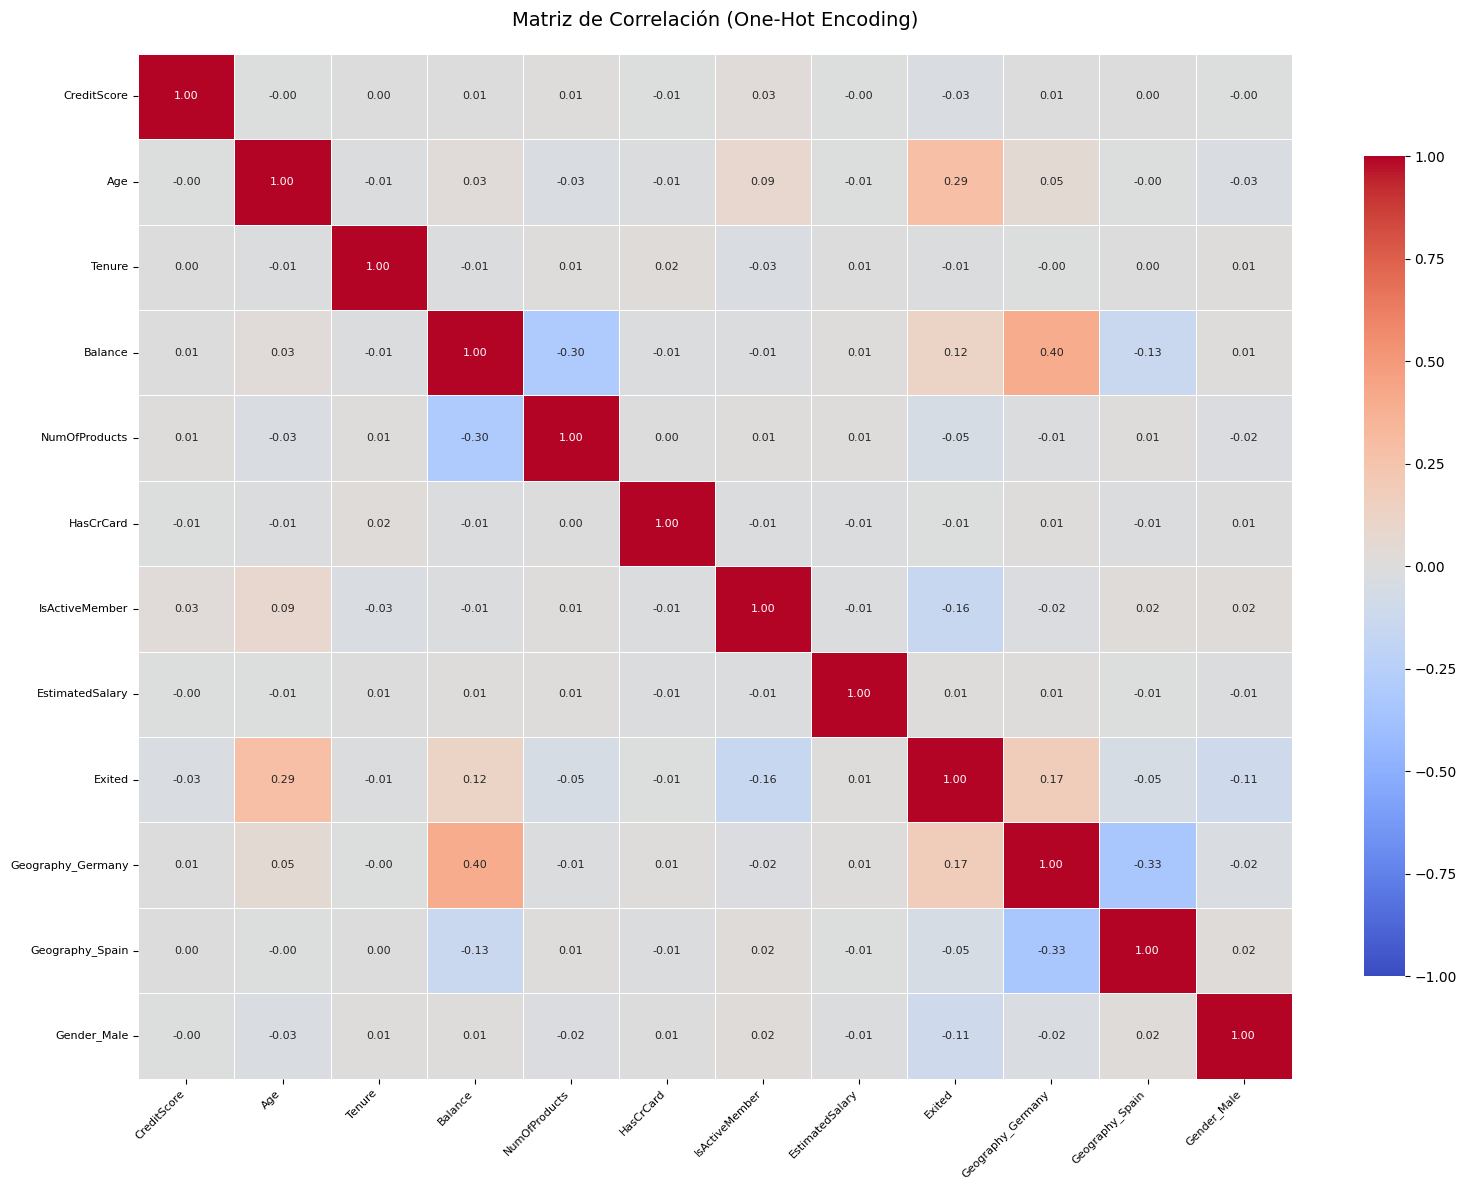

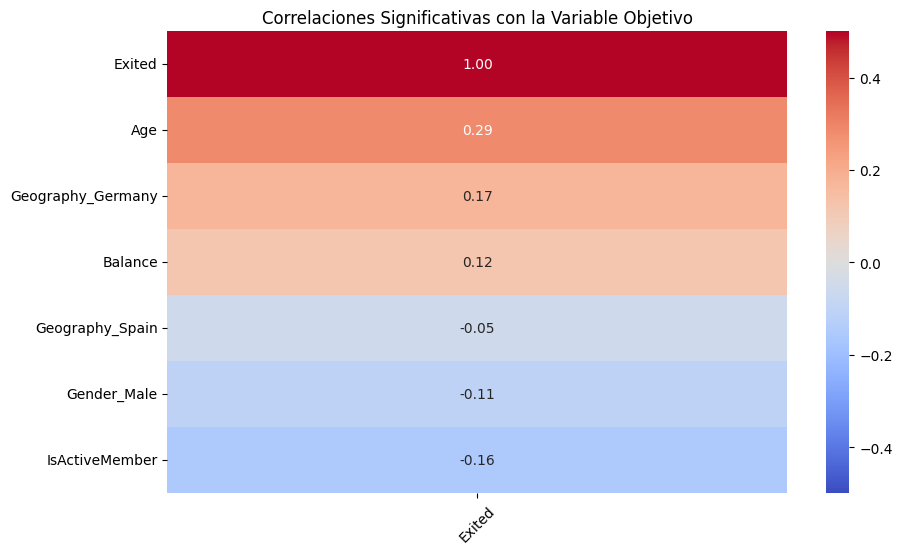

In [37]:
# Visualización inicial
plt.figure(figsize=(6, 6))
df['Exited'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['No abandonaron', 'Abandonaron'],
    colors=sns.color_palette("Accent"),
    title='Distribución de clientes que abandonaron'
)
plt.show()

# Visualización geográfica
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Geography', hue='Exited', data=df, palette='Accent')
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.title('Abandono por Ubicación Geográfica')
plt.show()

# Análisis de edad
df['AgeGroup'] = pd.cut(df['Age'], bins=range(0, 101, 10), 
                       labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['Exited'] == 1], x='Age', bins=range(0, 101, 10), 
             color='lightgreen', kde=False)
plt.title('Distribución de Edades en Clientes que Abandonaron')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Abandonos')
plt.show()

# Análisis de balance
plt.figure(figsize=(8, 6))
sns.boxplot(x="Exited", y="Balance", data=df, palette="Accent")
plt.title("Distribución de Saldos por Estado del Cliente")
plt.xticks([0, 1], ["No abandonaron", "Abandonaron"])
plt.show()

# Matriz de correlación con One-Hot Encoding (Corrección final)
df_encoded = df.drop(columns=["RowNumber", "CustomerId", "Surname", "AgeGroup"])
df_encoded = pd.get_dummies(df_encoded, columns=["Geography", "Gender"], drop_first=True)

plt.figure(figsize=(16, 12))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación (One-Hot Encoding)', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Vector de correlación
plt.figure(figsize=(10, 6))
corr_target = df_encoded.corr()[['Exited']].sort_values(by='Exited', ascending=False)
significant_corr = corr_target[(corr_target['Exited'] >= 0.05) | (corr_target['Exited'] <= -0.05)]
sns.heatmap(significant_corr, annot=True, cmap='coolwarm', fmt='.2f',
            vmin=-0.5, vmax=0.5, annot_kws={"size": 10})
plt.title('Correlaciones Significativas con la Variable Objetivo')
plt.xticks(rotation=45)
plt.show()

## 4. Preprocesamiento y Limpieza de Datos
- Identificación y manejo de valores nulos o duplicados.
- Transformaciones necesarias.
- Codificación y escalamiento si aplica.

In [38]:

# Preprocesamiento y Limpieza
# Limpieza final
df = df.drop(columns=["RowNumber", "CustomerId", "Surname", "AgeGroup"])

# Codificación
le = LabelEncoder()
df["Geography"] = le.fit_transform(df["Geography"])
df["Gender"] = le.fit_transform(df["Gender"])

# División de datos
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


## 5. Modelado Predictivo
- División de datos de entrenamiento y prueba.
- Selección de modelos.
- Entrenamiento y validación.

In [39]:
# Entrenamiento de modelos
# Configuración común para modelos
modelos = {}

In [40]:
# Random Forest - Yohana
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
modelos['Random Forest'] = rf

In [41]:
# Regresión Logística - José Lara
lr = linear_model.LogisticRegression(C=1, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
modelos['Regresión Logística'] = lr

In [42]:
#Árbol de Decisión - Gabriela
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
modelos['Árbol de Decisión'] = dt

In [ ]:
# LightGBM - Justin
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_fold_score = -np.inf
best_lgb = None

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    lgb_model = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    )
    
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=20)],
    )
    
    y_proba = lgb_model.predict_proba(X_val)[:, 1]
    current_score = roc_auc_score(y_val, y_proba)
    
    if current_score > best_fold_score:
        best_fold_score = current_score
        best_lgb = lgb_model

modelos['LightGBM'] = best_lgb

[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.858692	valid_0's binary_logloss: 0.437459
[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

In [51]:
# KNN - José V
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), ['Geography', 'Gender']),
    ('num', StandardScaler(), X.columns.difference(['Geography', 'Gender']))
])

knn_pipe = imbpipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': range(3, 20, 2),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

knn_model = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_model.fit(X_train, y_train)
modelos['KNN'] = knn_model.best_estimator_

## 6. Evaluación del Modelo
- Métricas de evaluación.
- Interpretación de resultados.
- Ajustes necesarios.


=== Random Forest ===
                precision    recall  f1-score   support

No Abandonaron       0.88      0.97      0.92      1593
   Abandonaron       0.78      0.46      0.58       407

      accuracy                           0.86      2000
     macro avg       0.83      0.71      0.75      2000
  weighted avg       0.86      0.86      0.85      2000



<Figure size 600x500 with 0 Axes>

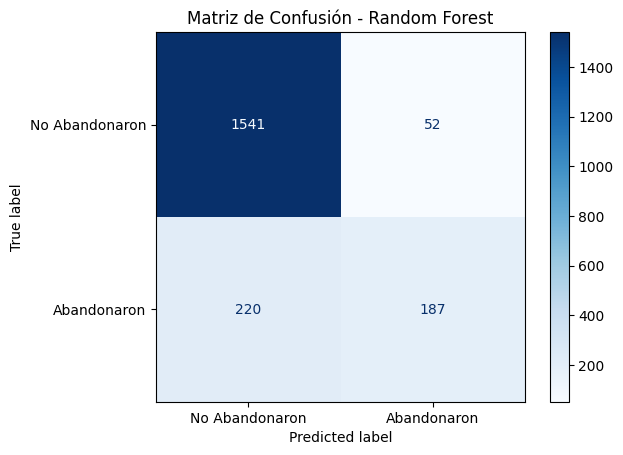

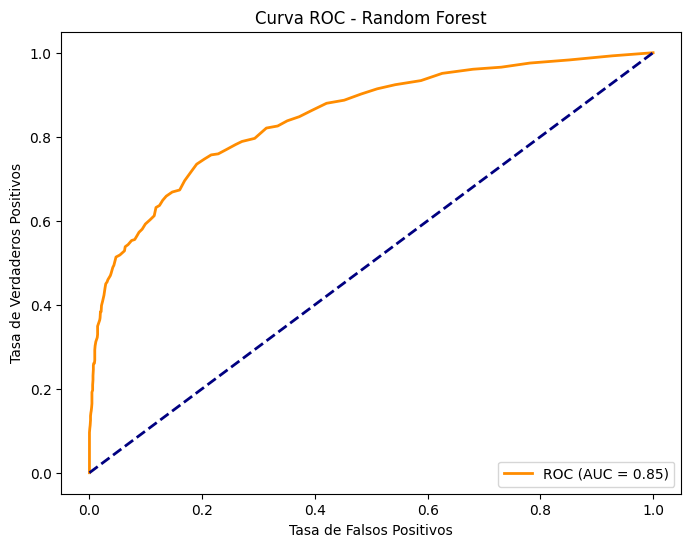


=== Regresión Logística ===
                precision    recall  f1-score   support

No Abandonaron       0.82      0.98      0.89      1593
   Abandonaron       0.60      0.14      0.23       407

      accuracy                           0.81      2000
     macro avg       0.71      0.56      0.56      2000
  weighted avg       0.77      0.81      0.75      2000



<Figure size 600x500 with 0 Axes>

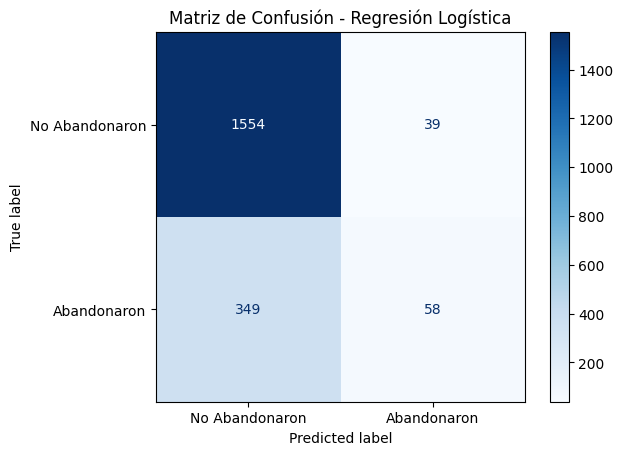

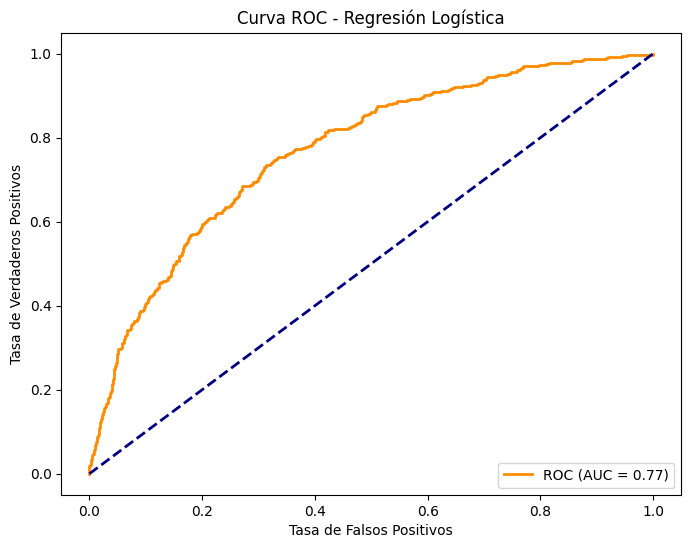


=== Árbol de Decisión ===
                precision    recall  f1-score   support

No Abandonaron       0.86      0.85      0.86      1593
   Abandonaron       0.45      0.48      0.46       407

      accuracy                           0.78      2000
     macro avg       0.66      0.66      0.66      2000
  weighted avg       0.78      0.78      0.78      2000



<Figure size 600x500 with 0 Axes>

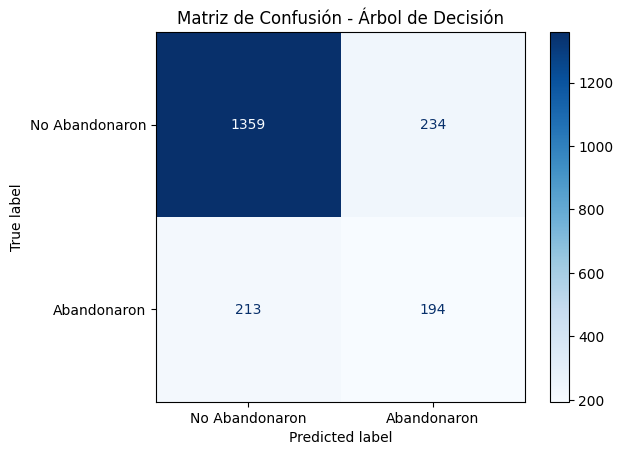

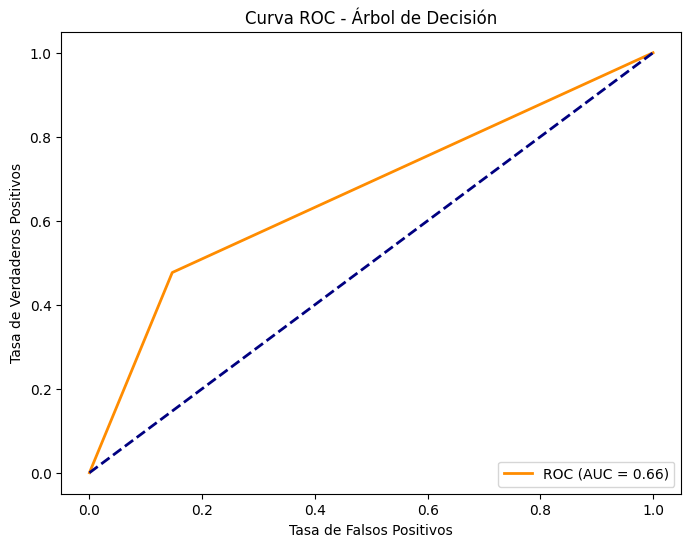


=== LightGBM ===
                precision    recall  f1-score   support

No Abandonaron       0.92      0.83      0.88      1593
   Abandonaron       0.53      0.73      0.61       407

      accuracy                           0.81      2000
     macro avg       0.73      0.78      0.74      2000
  weighted avg       0.84      0.81      0.82      2000



<Figure size 600x500 with 0 Axes>

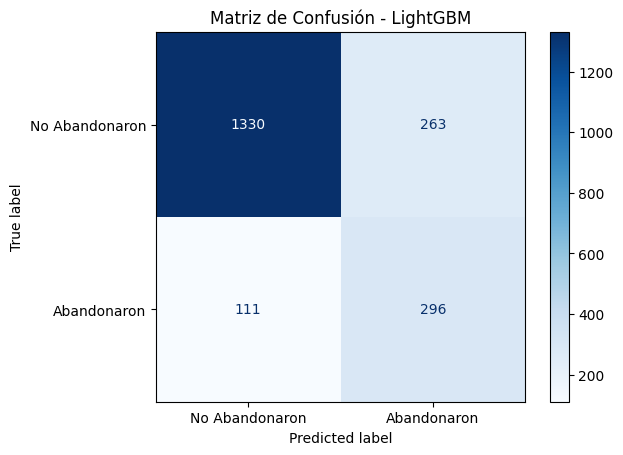

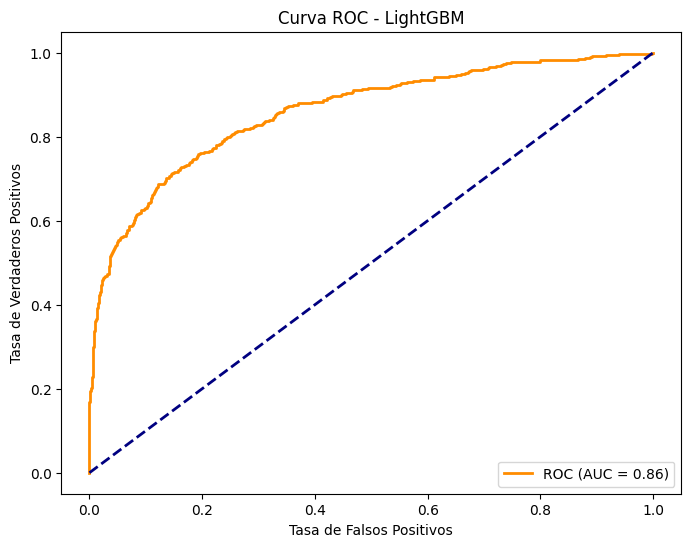


=== KNN ===
                precision    recall  f1-score   support

No Abandonaron       0.85      0.98      0.91      1593
   Abandonaron       0.81      0.31      0.45       407

      accuracy                           0.84      2000
     macro avg       0.83      0.65      0.68      2000
  weighted avg       0.84      0.84      0.82      2000



<Figure size 600x500 with 0 Axes>

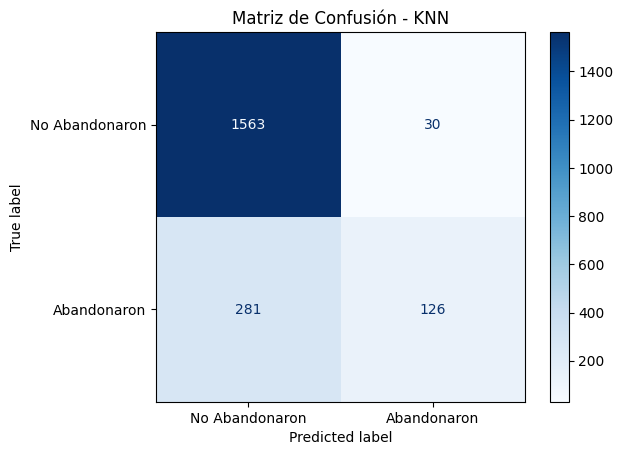

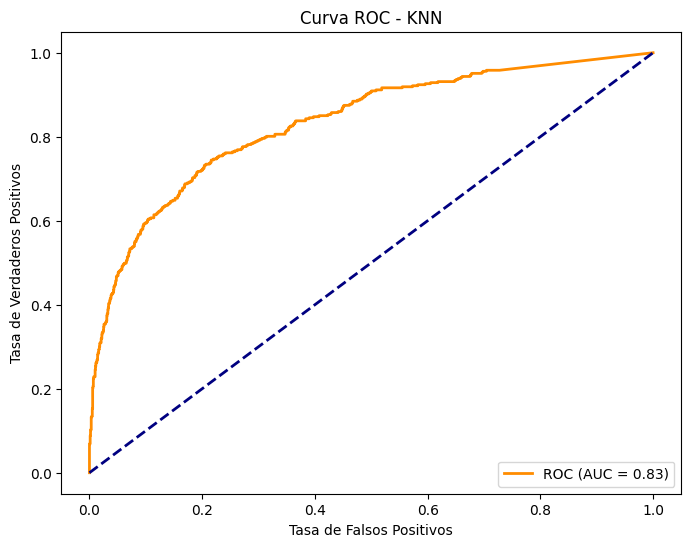

In [52]:
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None
    
    print(f"\n=== {nombre} ===")
    print(classification_report(y_test, y_pred, target_names=['No Abandonaron', 'Abandonaron']))
    
    # Matriz de Confusión
    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test,
                                        display_labels=['No Abandonaron', 'Abandonaron'],
                                        cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.show()
    
    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {nombre}')
        plt.legend(loc="lower right")
        plt.show()

for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_test, y_test)

## 7. Visualización de Resultados
- Crear visualizaciones relevantes.
- Mostrar resultados clave.

<Figure size 1200x800 with 0 Axes>

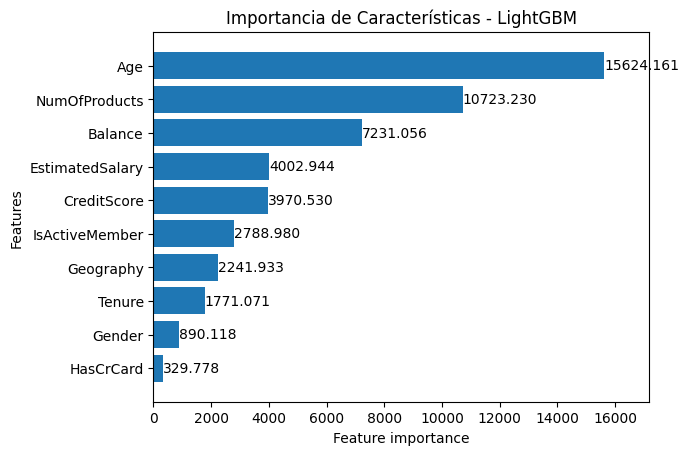

<Figure size 1200x600 with 0 Axes>

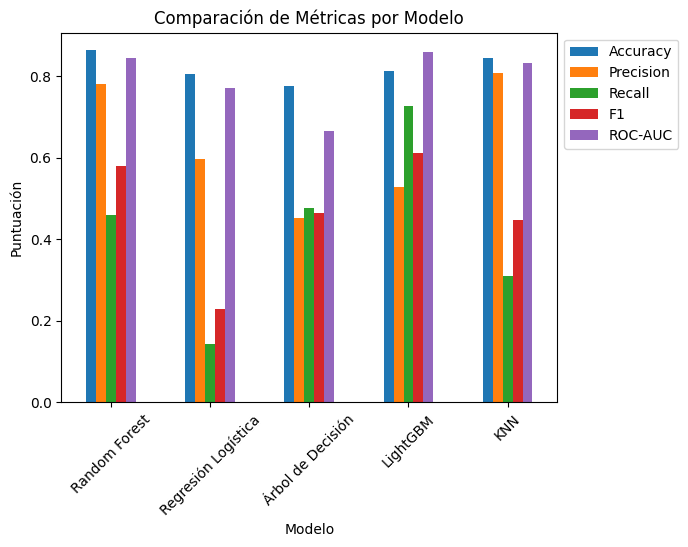

                     Accuracy  Precision    Recall        F1   ROC-AUC
Modelo                                                                
Random Forest          0.8640   0.782427  0.459459  0.578947  0.846417
Regresión Logística    0.8060   0.597938  0.142506  0.230159  0.770455
Árbol de Decisión      0.7765   0.453271  0.476658  0.464671  0.664883
LightGBM               0.8130   0.529517  0.727273  0.612836  0.860313
KNN                    0.8445   0.807692  0.309582  0.447602  0.832253


In [ ]:
# Importancia de características (LightGBM)
plt.figure(figsize=(12, 8))
lgb.plot_importance(best_lgb, importance_type='gain', max_num_features=15,
                    title='Importancia de Características - LightGBM', 
                    height=0.8, grid=False)
plt.show()

# Comparación de modelos
metricas = []
for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None
    
    metricas.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    })

df_metricas = pd.DataFrame(metricas).set_index('Modelo')
plt.figure(figsize=(12, 6))
df_metricas.plot(kind='bar', rot=45)
plt.title('Comparación de Métricas por Modelo')
plt.ylabel('Puntuación')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

print(df_metricas)

## 8. Conclusiones y Recomendaciones
- Conclusiones generales basadas en el análisis.
- Recomendaciones prácticas para el negocio.

Conclusión.
LightGBM es la mejor opción para minimizar el abandono no detectado, clave para estrategias de retención efectivas. Su alto recall garantiza que la mayoría de los clientes en riesgo sean identificados, permitiendo acciones tempranas incluso con un margen moderado de falsas alarmas.

Recomendación.
Implementar LightGBM para identificar clientes en riesgo, combinado con:
Acciones de retención proactivas (ofertas personalizadas, seguimiento especial).
Monitoreo de falsos positivos para ajustar campañas de retención.
Priorizar métricas de recall en la evaluación de modelos, ya que:
El costo de no detectar un abandono real es mayor que el de retener a un cliente leal.
Ejemplo: Si el banco tiene margen para retener 200 clientes, con LightGBM rescataría 146 abandonos reales (73% de 200), frente a 92 con Random Forest (46%).

## 9. Documentación Técnica
- Explicación de cómo ejecutar el proyecto paso a paso.
- Herramientas utilizadas con breve descripción y enlaces.
- Repositorio con código/documentación si aplica.


Requisitos:
- Python 3.8+
- Librerías: pandas, scikit-learn, lightgbm, matplotlib
Ejecución:
1. Instalar dependencias: pip install -r requirements.txt
2. Eiecutar celda por celda del Notebook

## 10. Recursos Adicionales
- Enlaces útiles.
- Lecturas recomendadas.
- Otros materiales de apoyo.

Enlaces Útiles
- Documentación LightGBM: https://lightgbm.readthedocs.io/
- Guía de métricas: https://developers.google.com/machine-learning/crash-course/classification